In [19]:
import numpy as np

import holoviews as hv
from holoviews.operation import decimate
from holoviews.operation.datashader import datashade

import itertools
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, push_notebook
from bokeh.palettes import viridis as viridis

## Code

The code being targeted is provided here for ref.

```C
    nblimbs = E->n;
    bufsize = 0;
    nbits   = 0;
    wbits   = 0;
    state   = 0;
    
    //TRIGGER STARTS HERE

    while( 1 )
    {
        if( bufsize == 0 )
        {
            if( nblimbs == 0 )
                break;

            nblimbs--;

            bufsize = sizeof( mbedtls_mpi_uint ) << 3;
        }

        bufsize--;

        ei = (E->p[nblimbs] >> bufsize) & 1;

        /*
         * skip leading 0s
         */
        if( ei == 0 && state == 0 )
            continue;

        if( ei == 0 && state == 1 )
        {
            /*
             * out of window, square X
             */
            MBEDTLS_MPI_CHK( mpi_montmul( X, X, N, mm, &T ) );
            continue;
        }

        /*
         * add ei to current window
         */
        state = 2;

        nbits++;
        wbits |= ( ei << ( wsize - nbits ) );

        if( nbits == wsize )
        {
            //WINDOW-ONLY TRIGGER STARTS HERE
            /*
             * X = X^wsize R^-1 mod N
             */
            for( i = 0; i < wsize; i++ )
                MBEDTLS_MPI_CHK( mpi_montmul( X, X, N, mm, &T ) );

            /*
             * X = X * W[wbits] R^-1 mod N
             */
            MBEDTLS_MPI_CHK( mpi_montmul( X, &W[wbits], N, mm, &T ) );

            //WINDOW-ONLY TRIGGER STOPS HERE

            if(global_en_triger)cnt--;
            state--;
            nbits = 0;
            wbits = 0;
            
        }
    }

    //TRIGGER STOPS HERE
    
```

## Brief explanation of what is happening

* wsize = 5
* Secret value being processed: C1ACF567564274FB07A0BBAD5D26E2983C94D22288ACD763FD8E5600ED4A702DF84198A5F06C2E72236AE490C93F07F83CC559CD27BC2D1CA488811730BB5725

The secret (ei) is being processed bit per bit. The code starts by looking for all leading 0s (state == 0) and skips them. A new window is formed when the first 1 occurs (state == 2), each window is of size 5 and always starts with a 1. Once a window is processed the state is decremented (state == 1) and the 0s interconnecting two windows are processed until a 1 occurs and thus a new window is processed.

In [10]:
dp = int("C1ACF567564274FB07A0BBAD5D26E2983C94D22288ACD763FD8E5600ED4A702DF84198A5F06C2E72236AE490C93F07F83CC559CD27BC2D1CA488811730BB5725", 16)
#From left is how this will be proccessed
#The cast to bin automatically excludes leading 0s :)
str_dp_value = bin(dp)[2:]

In [11]:
#Make operation list from the known algorithm

i = 0
total_ops = 0
op_list = ""
try:
    while True:
        b = str_dp_value[i]

        if (b == '0'):
            op_list += "s"
            total_ops += 1
            i += 1
        else:
            op_list += "xxxxxm"
            total_ops += 6
            i += 5
except IndexError:
    pass

print(op_list)

xxxxxmssxxxxxmxxxxxmxxxxxmsxxxxxmsxxxxxmsxxxxxmsxxxxxmxxxxxmxxxxxmxxxxxmsxxxxxmssxxxxxmxxxxxmsxxxxxmsxxxxxmsxxxxxmxxxxxmsxxxxxmsxxxxxmxxxxxmsxxxxxmsssssxxxxxmsxxxxxmxxxxxmsxxxxxmssxxxxxmsxxxxxmsssxxxxxmxxxxxmsxxxxxmsxxxxxmxxxxxmxxxxxmxxxxxmxxxxxmsxxxxxmssssssssxxxxxmxxxxxmssxxxxxmxxxxxmssssxxxxxmxxxxxmxxxxxmxxxxxmsxxxxxmxxxxxmsxxxxxmxxxxxmsssssxxxxxmssssxxxxxmssxxxxxmxxxxxmsssxxxxxmsxxxxxmxxxxxmssxxxxxmsssxxxxxmssxxxxxmxxxxxmssssxxxxxmxxxxxmsssxxxxxmsxxxxxmxxxxxmsxxxxxmxxxxxmxxxxxmxxxxxmxxxxxmxxxxxmsxxxxxmxxxxxmxxxxxmsxxxxxmsxxxxxmsssxxxxxmssxxxxxmsxxxxxmxxxxxmsxxxxxmsxxxxxmxxxxxmssxxxxxmxxxxxm


## Download, load and plot the RSA traces.
The next cell has to be executed only once and downloads the traces to the current working directory.
The rsa_trace_110x0 traces only include samples from a single processing window.

WARNING: The trace doesn't neccesarily cover all bits (few processed at end missing in trace).

In [14]:
!wget https://github.com/colinoflynn/mbedtls-rsa-inprogress/raw/master/traces/rsa_full.npy
!wget https://github.com/colinoflynn/mbedtls-rsa-inprogress/raw/master/traces/rsa_trace_11000.npy
!wget https://github.com/colinoflynn/mbedtls-rsa-inprogress/raw/master/traces/rsa_trace_11010.npy

--2019-09-29 15:59:56--  https://github.com/colinoflynn/mbedtls-rsa-inprogress/raw/master/traces/rsa_full.npy
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/colinoflynn/mbedtls-rsa-inprogress/master/traces/rsa_full.npy [following]
--2019-09-29 15:59:56--  https://raw.githubusercontent.com/colinoflynn/mbedtls-rsa-inprogress/master/traces/rsa_full.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48000128 (46M) [application/octet-stream]
Saving to: ‘rsa_full.npy.1’

100%[======================================>] 48,000,128  71.4MB/s   in 0.6s   

2019-09-29 15:59:57 (71.4 MB/s) - ‘rsa_full.npy.1’ saved [48000128/48000128]

--2019-09-29

In [15]:
rsa_trace_full = np.load('rsa_full.npy')
rsa_trace_11000 = np.load('rsa_trace_11000.npy')
rsa_trace_11010 = np.load('rsa_trace_11010.npy')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
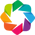

:DynamicMap   []
   :RGB   [x,y]   (R,G,B,A)

In [59]:
hv.extension('bokeh')
datashade(hv.Curve(rsa_trace_full)).opts(width=900, height=600)

## Splitting the trace into blocks
It turns out we can easily distinguish the calls to mpi_montmul(). During the processing of each window 6 calls will be made to this function and one call will be made for each 0 between windows. We split the block based on a threshold value.

In [17]:
#Get actual list - we split based on threshold, and check for delta between operations. Delta should be in ~9000-9800 range (code is not time constant)
#Deal with mutliple hits in a row by getting first threshold
loc = np.where(rsa_trace_full > 0.185)[0]

t_split_array = []
t_startloc_array = []

start_location = []

for i in range(0, len(loc)-1): # @Colin, I'm not sure why we have the -1 here?
    diff = loc[i+1]-loc[i]
    if (diff > 1):
        start_location.append(loc[i])

    if (diff > 1 and diff < 9000):
        print(diff)

    if (diff > 10000):
        print(diff)

# @Colin: We might have to add an extra split containing the data before the first element in loc so that we don't lose the first window
for i in range(0, len(start_location)-1):
    t_split = rsa_trace_full[start_location[i]:start_location[i+1]]
    t_startloc_array.append(start_location[i])
    t_split_array.append(t_split)

print("Found %d items" % len(t_split_array))

Found 593 items


In [60]:
# @Colin: as we are removing the first ~1200 samples from the trace we might have to reconsider which parts of the trace belong to which operation.
print(loc)

[   1184   10361   19538   28715   37892   47070   56267   65473   74800
   83990   93232  102448  111638  120855  130212  139402  148628  157818
  167018  176193  185535  194725  203915  213118  222357  231548  240768
  250111  259301  268491  277691  286881  296085  305292  314635  323825
  333028  342218  351473  360687  369910  379276  388466  397692  406882
  416072  425247  434483  443833  453023  462213  471403  480593  489784
  499118  508321  517524  526701  535875  545066  554428  563605  572795
  581995  591185  600363  609700  618877  628067  637257  646483  655661
  664884  674237  683440  692643  701872  711062  720240  729450  738656
  748033  757223  766426  775642  784832  794036  803377  812567  821741
  830931  840131  849309  858519  867844  877021  886211  895427  904640
  913815  923038  932389  941589  950779  959969  969146  978350  987560
  996934 1006124 1015327 1024517 1033733 1042924 1052279 1061469 1070685
 1079927 1089130 1098360 1107593 1116941 1126131 11

In [31]:
def plotTraces(traces, window=()):
    n = len(traces)
    
    output_notebook()
    p = figure(sizing_mode='scale_width', plot_height=300)

    # create a color iterator
    colors = itertools.cycle(viridis(n)) 

    for i, color in zip(range(0,n), colors):
        p.line(range(len(traces[i][window])), traces[i][window], color=color)

    show(p)

In [58]:
plotTraces(t_split_array[0:10])

Loading BokehJS ...

## Identifying processing windows
Because the algorithm always calls the mul(), we cannot easily view the difference between square/mul operations.

We instead use the time delta between mul() operations. Basically the idea is as follows:

The start of a window involves collecting 5 bits. This loop will add a longer delay before the call to mul() compared to running inside the loop.
Look for a longer delay to find the location of window starts. Once we know the window locations, we can find any extra squares (telling us 0-bits).

In [57]:
plotTraces(t_split_array[0:30], slice(7500,10000))

Loading BokehJS ...

In [40]:
deltalist = []

# We use a dumb high-point to decide where the mul ends and the next mul begins.

for i in range(0, len(t_split_array)):
    whlow = np.where(t_split_array[i][7500:8500] > 0.13)
    whhi = np.where(t_split_array[i][8200:] > 0.15)

    d = (whhi[0] + 8200) - (whlow[0] + 7500)
  
    deltalist.append(d[0])
    
print(deltalist)

[1497, 1497, 1497, 1497, 1498, 1517, 1526, 1647, 1510, 1497, 1497, 1497, 1511, 1651, 1510, 1494, 1510, 1494, 1495, 1662, 1510, 1510, 1510, 1481, 1511, 1514, 1663, 1510, 1510, 1481, 1510, 1498, 1514, 1663, 1510, 1510, 1510, 1510, 1495, 1530, 1634, 1510, 1494, 1510, 1510, 1495, 1530, 1657, 1510, 1510, 1510, 1510, 1498, 1654, 1510, 1497, 1497, 1494, 1511, 1656, 1497, 1510, 1481, 1497, 1498, 1657, 1497, 1510, 1510, 1481, 1498, 1530, 1660, 1510, 1510, 1497, 1497, 1498, 1530, 1513, 1658, 1497, 1510, 1510, 1497, 1511, 1661, 1510, 1494, 1510, 1481, 1498, 1530, 1645, 1497, 1510, 1510, 1481, 1495, 1530, 1645, 1494, 1510, 1510, 1497, 1498, 1517, 1668, 1497, 1497, 1497, 1497, 1498, 1662, 1510, 1510, 1510, 1497, 1511, 1514, 1668, 1510, 1510, 1497, 1494, 1511, 1530, 1658, 1510, 1494, 1510, 1481, 1511, 1656, 1510, 1510, 1497, 1497, 1498, 1514, 1650, 1510, 1510, 1494, 1510, 1498, 1501, 1526, 1513, 1531, 1513, 1658, 1510, 1481, 1510, 1481, 1498, 1530, 1652, 1510, 1494, 1510, 1510, 1511, 1651, 1510, 151

In [41]:
# @Colin: we determine the time delta within each subtrace right? Why do we not have a time delta for the first window start?

for i in range(1, len(t_split_array)):
    print("%s - %d"%(op_list[i], deltalist[i-1]))

x - 1497
x - 1497
x - 1497
x - 1497
m - 1498
s - 1517
s - 1526
x - 1647
x - 1510
x - 1497
x - 1497
x - 1497
m - 1511
x - 1651
x - 1510
x - 1494
x - 1510
x - 1494
m - 1495
x - 1662
x - 1510
x - 1510
x - 1510
x - 1481
m - 1511
s - 1514
x - 1663
x - 1510
x - 1510
x - 1481
x - 1510
m - 1498
s - 1514
x - 1663
x - 1510
x - 1510
x - 1510
x - 1510
m - 1495
s - 1530
x - 1634
x - 1510
x - 1494
x - 1510
x - 1510
m - 1495
s - 1530
x - 1657
x - 1510
x - 1510
x - 1510
x - 1510
m - 1498
x - 1654
x - 1510
x - 1497
x - 1497
x - 1494
m - 1511
x - 1656
x - 1497
x - 1510
x - 1481
x - 1497
m - 1498
x - 1657
x - 1497
x - 1510
x - 1510
x - 1481
m - 1498
s - 1530
x - 1660
x - 1510
x - 1510
x - 1497
x - 1497
m - 1498
s - 1530
s - 1513
x - 1658
x - 1497
x - 1510
x - 1510
x - 1497
m - 1511
x - 1661
x - 1510
x - 1494
x - 1510
x - 1481
m - 1498
s - 1530
x - 1645
x - 1497
x - 1510
x - 1510
x - 1481
m - 1495
s - 1530
x - 1645
x - 1494
x - 1510
x - 1510
x - 1497
m - 1498
s - 1517
x - 1668
x - 1497
x - 1497
x - 1497
x

In [45]:
# @Colin: I prepended an extra delta (1605) to the deltalist so we also get the first window
deltalist.insert(0,1605)

In [46]:
#Find window starting points. Also print (from *known operations*) what is happening
#This is used to validate our method works OK for now.
window_starts = []

for i in range(0, len(t_split_array)):
    if deltalist[i] > 1600:
        print("window @ %d (%s)"%(i, op_list[i]+ op_list[i+1]+ op_list[i+2]+ op_list[i+3]+ op_list[i+4]+ op_list[i+5]))
        window_starts.append(i)

window @ 0 (xxxxxm)
window @ 8 (xxxxxm)
window @ 14 (xxxxxm)
window @ 20 (xxxxxm)
window @ 27 (xxxxxm)
window @ 34 (xxxxxm)
window @ 41 (xxxxxm)
window @ 48 (xxxxxm)
window @ 54 (xxxxxm)
window @ 60 (xxxxxm)
window @ 66 (xxxxxm)
window @ 73 (xxxxxm)
window @ 81 (xxxxxm)
window @ 87 (xxxxxm)
window @ 94 (xxxxxm)
window @ 101 (xxxxxm)
window @ 108 (xxxxxm)
window @ 114 (xxxxxm)
window @ 121 (xxxxxm)
window @ 128 (xxxxxm)
window @ 134 (xxxxxm)
window @ 141 (xxxxxm)
window @ 152 (xxxxxm)
window @ 159 (xxxxxm)
window @ 165 (xxxxxm)
window @ 172 (xxxxxm)
window @ 180 (xxxxxm)
window @ 187 (xxxxxm)
window @ 196 (xxxxxm)
window @ 202 (xxxxxm)
window @ 209 (xxxxxm)
window @ 216 (xxxxxm)
window @ 222 (xxxxxm)
window @ 228 (xxxxxm)
window @ 234 (xxxxxm)
window @ 240 (xxxxxm)
window @ 247 (xxxxxm)
window @ 261 (xxxxxm)
window @ 267 (xxxxxm)
window @ 275 (xxxxxm)
window @ 281 (xxxxxm)
window @ 291 (xxxxxm)
window @ 297 (xxxxxm)
window @ 303 (xxxxxm)
window @ 309 (xxxxxm)
window @ 316 (xxxxxm)
windo

In [56]:
#Print everything between the windows. If the algorithm is working OK
#this should only print 's' operations (squares). Note the first operation
#is technically "unknown" since we don't have the starting delta.

for i in range(len(window_starts)-1):
    diff = window_starts[i+1] - (window_starts[i]+6)
    for j in range(diff):
        print(op_list[window_starts[i]+6+j], window_starts[i]+6+j)

s 6
s 7
s 26
s 33
s 40
s 47
s 72
s 79
s 80
s 93
s 100
s 107
s 120
s 127
s 140
s 147
s 148
s 149
s 150
s 151
s 158
s 171
s 178
s 179
s 186
s 193
s 194
s 195
s 208
s 215
s 246
s 253
s 254
s 255
s 256
s 257
s 258
s 259
s 260
s 273
s 274
s 287
s 288
s 289
s 290
s 315
s 328
s 341
s 342
s 343
s 344
s 345
s 352
s 353
s 354
s 355
s 362
s 363
s 376
s 377
s 378
s 385
s 398
s 399
s 406
s 407
s 408
s 415
s 416
s 429
s 430
s 431
s 432
s 445
s 446
s 447
s 454
s 467
s 504
s 523
s 530
s 537
s 538
s 539
s 546
s 547
s 554
s 567
s 574
s 587
s 588


In [67]:
#Print window being operated on, along with points within the trace. Handy for
#checking various plots etc.

known_windows = {}

op_num = 0

i = 0
try:
    while True:
        b = str_dp_value[i]

        if (b == '0'):
            print("s")
            i += 1
            op_num += 1
        else:
            print("win(%x) - (%d - %d @ %d - %d)"%(int(str_dp_value[i:(i+5)], 2), op_num, op_num+5, t_startloc_array[op_num], t_startloc_array[op_num+5]))
            if str_dp_value[i:(i+5)] not in known_windows.keys():
                known_windows[str_dp_value[i:(i+5)]] = [op_num]
            else:
                known_windows[str_dp_value[i:(i+5)]].append(op_num)
            i += 5
            op_num += 6
        
except IndexError:
    pass

print(known_windows)

win(18) - (0 - 5 @ 1184 - 47070)
s
s
win(1a) - (8 - 13 @ 74800 - 120855)
win(19) - (14 - 19 @ 130212 - 176193)
win(1d) - (20 - 25 @ 185535 - 231548)
s
win(16) - (27 - 32 @ 250111 - 296085)
s
win(1d) - (34 - 39 @ 314635 - 360687)
s
win(16) - (41 - 46 @ 379276 - 425247)
s
win(10) - (48 - 53 @ 443833 - 489784)
win(13) - (54 - 59 @ 499118 - 545066)
win(14) - (60 - 65 @ 554428 - 600363)
win(1f) - (66 - 71 @ 609700 - 655661)
s
win(18) - (73 - 78 @ 674237 - 720240)
s
s
win(1e) - (81 - 86 @ 748033 - 794036)
win(10) - (87 - 92 @ 803377 - 849309)
s
win(17) - (94 - 99 @ 867844 - 913815)
s
win(1d) - (101 - 106 @ 932389 - 978350)
s
win(1a) - (108 - 113 @ 996934 - 1042924)
win(17) - (114 - 119 @ 1052279 - 1098360)
s
win(12) - (121 - 126 @ 1116941 - 1162902)
s
win(1b) - (128 - 133 @ 1181476 - 1227538)
win(11) - (134 - 139 @ 1236874 - 1282825)
s
win(13) - (141 - 146 @ 1301401 - 1347453)
s
s
s
s
s
win(1e) - (152 - 157 @ 1402905 - 1448850)
s
win(12) - (159 - 164 @ 1467405 - 1513340)
win(13) - (165 - 170

* We now have the full RSA trace split up into basic operations. 
* We have learned when a new window with 5 bits is being processed and thus how many 0 bits are between windows.
* As each window starts with a 1 there are 4 unknown bits remaining per window.

The initial idea was to find all of the windows that process the same 5-bit value. While we made some progress in that direction we will first explore Yuval's idea as it has the potential to let us recover bit by bit.

#1 - the window bit collection

```C
        wbits |= ( ei << ( wsize - nbits ) );
 8003084: 1bd2       subs r2, r2, r7
 8003086: 4093       lsls r3, r2
 8003088: ea4a 0a03 orr.w sl, sl, r3
```
    
It would be small, but should see the HW diff. In theory I know the 1-bit of first window, so might work.

#2 - the earlier check

Earlier ei is checked outside the window (state = 0 / state = 1). But you can see here the way this is done is ei is checked *first*, so in fact my super-simple SPA attack should work once again :) rejoice :)

```C
       if( ei == 0 && state == 0 )
 8002f2e: f013 0301 ands.w r3, r3, #1
 8002f32: f040 80a5 bne.w 8003080 <mbedtls_mpi_exp_mod+0x348>
 8002f36: f1b8 0f00 cmp.w r8, #0
 8002f3a: d0e5       beq.n 8002f08 <mbedtls_mpi_exp_mod+0x1d0>
```

### Can we recover the value of ei by observing a difference in outcome of the ei==0 check?
This information should be contained within each of the window start subtraces

In [97]:
starts = [np.concatenate((np.zeros(9500-len(t_split_array[i-1])),t_split_array[i-1])) for i in known_windows['11111']]
test1 = np.mean(np.array(starts), axis=0)
plotTraces([test1], slice(7500,9500))

Loading BokehJS ...

In [98]:
starts = [np.concatenate((np.zeros(9500-len(t_split_array[i-1])),t_split_array[i-1])) for i in known_windows['10000']]
test2 = np.mean(np.array(starts), axis=0)
plotTraces([test2], slice(7500,9500))

Loading BokehJS ...

In [99]:

plotTraces([test1-test2], slice(7500,9500))

Loading BokehJS ...

In [107]:
means = []

for i, (k, v) in enumerate(known_windows.items()):
    print(i, k, v)
    starts = [np.concatenate((np.zeros(9500-len(t_split_array[j])),t_split_array[j])) for j in v]
    mean = np.mean(np.array(starts), axis=0)
    
    means.append(mean)

0 11000 [0, 73, 216, 455, 498, 561]
1 11010 [8, 108, 575]
2 11001 [14, 240, 316, 392, 409, 468, 474, 517]
3 11101 [20, 34, 101, 228, 261]
4 10110 [27, 41, 247, 291, 505]
5 10000 [48, 87, 303, 309, 540]
6 10011 [54, 141, 165, 202, 417, 486]
7 10100 [60, 275, 480]
8 11111 [66, 222, 297, 335, 433]
9 11110 [81, 152, 423, 448]
10 10111 [94, 114, 209, 356, 568, 581]
11 10010 [121, 159, 172, 329, 400, 524]
12 11011 [128, 346, 379, 492]
13 10001 [134, 180, 187, 234, 322, 370, 511, 531, 548]
14 10101 [196, 267, 386, 461]
15 11100 [281, 364, 439, 555]


In [108]:
plotTraces(means, slice(7500,9500))

Loading BokehJS ...

In [109]:
plotTraces([means[0]-means[1], means[0]-means[2], means[0]-means[3]], slice(7500,9500))

Loading BokehJS ...